# HandsOn-02-ParameterRecovery

## Part I. Using Frequency-Domain Data

Doing so using an FD system requires multiple source detector distances, and is therefore referred to as spatially resolved spectroscopy (SRS) or the multi-distance method. We will discuss two different flavors of how to do this, but the idea is essentially this: we assume the medium to be semi-infinite such that we know the analylitical form of the fluence, we then tweak the optical properties, such that calculated recording (using the analytical form) matches the actual recording. These current values would be our estimation of the optical properties of the medium.

Let's load an example mesh.

In [1]:
import sys
sys.path.insert(1, '../')
import nirfasterff as ff # ff is short for fast and furious
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mesh = ff.base.stndmesh()
mesh.from_file('slab_workshop')

Sources integration functions loaded
Detectors integration functions loaded


This is a 3D mesh of size 60mm x 60mm x 50mm, with one source and three detectors arranged in a row. The source-detector distances (let's call it $\rho$) in this example are 10mm, 20mm, 30mm, and 40mm. The optical properties are uniform in the mesh, with $\mu_a=0.01$mm$^{-1}$, $\mu_s'=1$mm$^{-1}$, and refractive index of 1.33. We can plot and have a look.

In [5]:
fig, ax = ff.visualize.plot3dmesh(mesh,selector='y>31')
ax.scatter(mesh.source.coord[0,0], mesh.source.coord[0,1], mesh.source.coord[0,2], color='r')
ax.scatter(mesh.meas.coord[:,0], mesh.meas.coord[:,1], mesh.meas.coord[:,2], color='b')
plt.show()

We usually leverage two pieces of information: log intensity vs source-detector distance, and phase vs source-detector distance. Let's generate some data and have a look.

In [13]:
# let's generate some FD data, and have a look
data = mesh.femdata(1e8)[0] # 100MHz modulation
rho = np.array([10., 20, 30, 40])

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(rho, np.log(data.amplitude))
ax1.set_xlabel('source detector distance (mm)')
ax1.set_ylabel('log amplitude (au)')

ax2.plot(rho, data.phase)
ax2.set_xlabel('source detector distance (mm)')
ax2.set_ylabel('phase (degrees)')

plt.tight_layout()
plt.show()

### Method 1

We can, of course, calculate the exact same curves using the analytical solutions in semi-infinte media, using the functions provided in the NIRFASTer package. When the "correct" optical parameters are used, they should match exactly. Conveniently, we can use the `curve_fit` function provided by SciPy to look for these parameters to make the exact match.

We must be cautious, that since the FEM solution (or an experimental recording) and the analytical solution are often at completely different amplitudes, and consequently it is usually a good idea to shift the curves along the y-axis, such that the first point is zero. 

In [14]:
from scipy import optimize
def myfunc(rho, mua, musp):
    phi = ff.forward.semi_infinite_FD(mua, musp, 1.33, 1e8, rho)
    amplitude = np.log(np.abs(phi))
    phase = np.angle(phi, deg=True)
    return np.r_[amplitude-amplitude[0], phase-phase[0]] # make sure to normalize to the first position

# log intensity and phase concatenated to form the measurement vector
ydata = np.r_[np.log(data.amplitude/data.amplitude[0]), data.phase-data.phase[0]]
# we need to specify the bounds of the search
# let's say mua must be between 0.001~0.1 mm-1, and musp 0.1~10 mm-1
fitted = optimize.curve_fit(myfunc, rho, ydata, bounds=([1e-3, 1e-1], [1e-1, 1e1]))[0]
print('fitted: mua=%f, musp=%f'%(fitted[0], fitted[1]))

fitted: mua=0.010009, musp=0.995485


We can also plot the analytical results using the fitted parameters together with the FEM results, and see how good our fit is.

In [15]:
yhat = myfunc(rho, fitted[0], fitted[1])

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(rho, ydata[:4])
ax1.plot(rho, yhat[:4], 'o')
ax1.set_xlabel('source detector distance (mm)')
ax1.set_ylabel('log amplitude (au, normalized)')
ax1.legend(['truth', 'from fitted'])

ax2.plot(rho, ydata[4:])
ax2.plot(rho, yhat[4:],'o')
ax2.set_xlabel('source detector distance (mm)')
ax2.set_ylabel('phase (degrees, normalized)')
ax2.legend(['truth', 'from fitted'])

plt.tight_layout()
plt.show()

### Exercise 1

In the last session, we looked at how the modulation frequency affects the measured phase. Please repeat the experiment by performing parameter fitting at different modulation frequencies.

*Hint: the modulation frequency must be changed at two places: in FEM data generation and in myfunc()*

### Exercise 2

Sometimes we do not have access to the exact refractive index of the medium and have to make "educated guesses". While this is not ideal, a *slightly* inaccurate refractive index usually don't bias the estimation of $\mu_a$ and $\mu_s'$ too much. Please vary the assumed refractive index when calculating the analytical solution (i.e. the 1.33 in the first line of myfunc()), and observe how it affects the fitted results.

### Method 2

In fact, according to the analytical solution, in high scattering media ($1/\mu_s'\ll\rho$, $\rho$ being the source-detector distances), the phase has a linear relationship with $\rho$, and a slightly modified version of the log intensity, $\log(\rho^2I)$, also scales linearly with $\rho$. Let's have a look at the latter.

plt.plot(rho, np.log(rho**2 * data.amplitude))
plt.xlabel('source detector distance (mm)')
plt.ylabel('$log(r^2 I_{AC})$')
plt.show()

Now if we calculate the slopes of the two curves ($\log(\rho^2I)\sim\rho$ and $\phi\sim\rho$), we can use them to very conveniently give an estimation of the optical properties. And this motivates our flavor number two. Assuming that the semi-infinite analytical solution is used, the relationship is given by, if we denote the two slopes by $S_{ac}$ and $S_\phi$,
$$
\mu_a=\frac{\omega}{2\nu}\left(\frac{S_\phi}{S_{ac}} - \frac{S_{ac}}{S_\phi}\right)
$$
$$
\mu_s'=\frac{S_{ac}^2-S_\phi^2}{3\mu_a}-\mu_a
$$
This is given [here](https://doi.org/10.1088/0031-9155/44/6/308).

In the following cell, I'm fitting for the slope (in $y=a+bx$) using the least square method, but organized in the matrix form.

In [17]:
slope_ac = np.linalg.pinv(np.c_[np.ones(4), rho]) @ np.log(rho**2 * data.amplitude)
slope_ac = slope_ac[1]
slope_phi = np.linalg.pinv(np.c_[np.ones(4), rho]) @ (data.phase/180*np.pi) # imoprtant: use radian
slope_phi = slope_phi[1]

omega = 2*np.pi*1e8
v = 3e11 / 1.33
mua_fitted = 0.5*omega/v * (slope_phi/slope_ac - slope_ac/slope_phi)
musp_fitted = (slope_ac**2 - slope_phi**2)/3/mua_fitted - mua_fitted

print('fitted: mua=%f, musp=%f'%(mua_fitted, musp_fitted))

fitted: mua=0.010899, musp=0.962734


### Exercise 3
It was previously mentioned that this method works only when the scattering coefficient is sufficiently high. In this exercise, please reduce the scattering coefficient, repeat the previous processes, and observe two things: how it affects the linearity of $\log(\rho^2I)\sim\rho$ and $\phi\sim\rho$, and how it affects the fitting accuracy.

Here is a start.

In [18]:
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)

In [ ]:
new_musp = 0.5*mesh.mus[0] # <-- experiment with this 0.5 factor
mesh2.change_prop(-1, [0.01, new_musp, 1.33]) # mua and ri remain the same
mesh2.touch_optodes() # adjust the optode positions: this is important when mus' has a dramatic change

data2 = mesh2.femdata(1e8)[0] # 100MHz modulation
rho = np.array([10., 20, 30, 40])

fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(rho, np.log(rho**2 * data2.amplitude))
ax1.set_xlabel('source detector distance (mm)')
ax1.set_ylabel('$log(r^2 I)$')

ax2.plot(rho, data.phase)
ax2.set_xlabel('source detector distance (mm)')
ax2.set_ylabel('phase (degrees)')

plt.tight_layout()
plt.show()

In [ ]:
# And how about the fitted results?

## Part II. Using Time-Resolved Data

The nice thing about time-resolved measurement is that we can leverage the shape information of *a* TPSF, and therefore use only one source and one detector. The idea is very similar to what we used in the last tutorial: find the combination of $\mu_a$ and $\mu_s'$, such that the analytical TPSF and the measured TPSF have the same shape. We can also use the TPSF slightly differently by using its moments: if we compare the analytical version of the first and second moments with the measured, we have a second way of fitting optical parameters. We will discuss a third way of using TR data by combining moments and multi-distance methods later, but let's first start with flavor number one.

## Method 1.

Here we use ONE TPSF and fit for its shape. Calculate the TPSF and have a look at one of them.

In [33]:
data = mesh.femdata_tpsf(5e-9, 1e-11)[0]

plt.plot(data.time*1e9, data.tpsf[1,:])
plt.xlabel('time (ns)')
plt.ylabel('tpsf')
plt.title('S-D distance=20mm')
plt.show()

Now let's do the fitting

In [34]:
from scipy import optimize
def myfunc(tvec, mua, musp):
    phi = ff.forward.semi_infinite_TR(mua, musp, 1.33, 20, tvec, 0, boundary='ebc-exact') # the '0' argument is dt, which has no effect here
    return phi[:,1] / phi.max() # normalize amplitude to 1

ydata = data.tpsf[1,1:].squeeze() / data.tpsf[1,:].max()
# we need to specify the bounds of the search
# let's say mua must be between 0.001~0.1 mm-1, and musp 0.1~10 mm-1
fitted = optimize.curve_fit(myfunc, data.time[1:], ydata, bounds=([1e-3, 1e-1], [1e-1, 1e1]))[0]

print('fitted: mua=%f, musp=%f'%(fitted[0], fitted[1]))

fitted: mua=0.010484, musp=1.019439


We can plot the analytical results using the fitted parameters together with the FEM results, and see how good our fit is.

In [35]:
plt.plot(data.time*1e9, data.tpsf[1,:]/data.tpsf[1,:].max())
plt.plot(data.time[1:]*1e9, myfunc(data.time[1:], fitted[0], fitted[1]), 'o')
plt.xlabel('time (ns)')
plt.ylabel('tpsf')
plt.legend(['truth', 'from fitted'])

plt.show()

### Exercise 4

Try to repeat the fitting using the other TPSFs and think: does the source-detector distance affect the goodness of fit, and why?

### Method 2

Now let's have a look at flavor number two: using moments, or specifically, the mean time of flight and the variance of the time of flight. If we use the solution in semi-infinite media, denote the source-detector distance by $\rho$, according to [this paper](https://doi.org/10.1364/AO.42.005785), the optical properties are given by,
$$
\mu_a=\frac{m_1^3}{2\nu V(m_1^2+V)}
$$
$$
\mu_s'=\frac{2m_1\nu(m_1^2+V)}{3\rho^2V}
$$
where $\nu$ is the light speed in the medium, $m_1=\langle t\rangle$, $V=\langle t^2\rangle-\langle t\rangle^2$, and if we denote the TPSF by $g(t)$, $\langle t^k\rangle=\frac{\int_{-\infty}^\infty t^kg(t)dt}{\int_{-\infty}^\infty g(t)dt}$.

Let's give it a try.

In [36]:
dt = 1e-11

m0 = np.sum(data.tpsf[1,:]*dt) # using the second tpsf
m1 = np.sum(data.time * data.tpsf[1,:]*dt) / m0
m2 = np.sum(data.time**2 * data.tpsf[1,:]*dt) / m0
V = m2 - m1**2

v = 3e11/1.33
rho = 20.
mua_hat = m1**3 / (2*v*V*(m1**2 + V))
musp_hat = 2*m1*v*(m1**2 + V) / (3 * rho**2 * V)

print('fitted: mua=%f, musp=%f'%(mua_hat, musp_hat))

fitted: mua=0.010439, musp=1.071564


### Exercise 5

Repeat exercise 4: do the fitting using the other TPSFs and observe if the source-detector distance makes an impact on the goodness of fit.

### Method 3

Under further approximation when $\rho\gg1/\sqrt{3\mu_a\mu_s'}$, the semi-infinite medium solution actually merges into the infinite medium, in which case, very nicely, both $m_1$ and $V$ scale linearly with $\rho$. Therefore, if we measure these two quantities at multiple distances, we can use the slope for calculating $\mu_a$ and $\mu_s'$.

Let's first plot them, and make sure the linear approximation is a reasonable one.

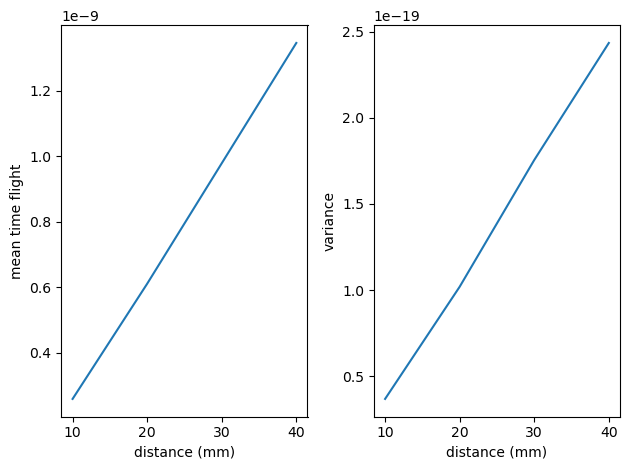

In [37]:
m0 = np.sum(data.tpsf*dt, axis=1)
m1 = np.sum(data.time * data.tpsf*dt, axis=1) / m0
m2 = np.sum(data.time**2 * data.tpsf*dt, axis=1) / m0
V = m2 - m1**2

rho = np.array([10., 20., 30, 40])
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(rho, m1)
ax1.set_xlabel('distance (mm)')
ax1.set_ylabel('mean time flight')

ax2.plot(rho, V)
ax2.set_xlabel('distance (mm)')
ax2.set_ylabel('variance')

plt.tight_layout()
plt.show()

That's fairly linear. If we denote the two slopes by $S_1$ and $S_2$, rearranging the expressions from [this paper](https://doi.org/10.1364/AO.42.005785) gives us
$$
\mu_a=\frac{S_1}{2\nu S_2}
$$
$$
\mu_s'=\frac{2\nu S_1^3}{3 S_2}-\mu_a
$$

Let's have a try.

In [43]:
s1 = np.linalg.pinv(np.c_[np.ones(4), rho]) @ m1
s1 = s1[1]
s2 = np.linalg.pinv(np.c_[np.ones(4), rho]) @ V
s2 = s2[1]

mua_hat = s1/(2*v*s2)
musp_hat = (2*v*s1**3)/(3*s2) - mua_hat

print('fitted: mua=%f, musp=%f'%(mua_hat, musp_hat))

fitted: mua=0.011586, musp=1.020636


You may have noticed that the variances are quite small, and it's not hard to imagine that in real-life data where noise is present, the estimation of it can be inaccurate. If you do wish to use the moments (Methods \#2 and \#3 discussed here) for parameter recovery, you need to be very cautious.

Of course, instead of the first and the second moments, you can elect to use the *zeroth* (that is, the intensity) and first moments in order to avoid concerns about noisy variance estimation. The curious reader is encouraged to derive the expressions for themselves.

### Exercise 6 (optional)

We know that this last method relies on some rather strong assumptions, most notably $\rho\gg1/\sqrt{3\mu_a\mu_s'}$, suggesting that when $\mu_s'$ is small, the method may break down. In this exercise, please lower the reduced scattering coefficient, and observe if the relationships $m_1\sim\rho$ and $V\sim\rho$ become non-linear.

In [ ]:
mesh2 = ff.base.stndmesh()
mesh2.from_copy(mesh)

new_musp = 0.5*mesh.mus[0] # <-- experiment with this 0.5 factor
mesh2.change_prop(-1, [0.01, new_musp, 1.33]) # mua and ri remain the same
mesh2.touch_optodes() # adjust the optode positions: this is important when mus' has a dramatic change

data2 = mesh2.femdata_tpsf(5e-9, 1e-11)[0]

# please continue from here